# Train TF-IDF

In [191]:
import pickle
import pandas as pd
from ast import literal_eval
from sklearn.model_selection import GridSearchCV 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import gensim
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.feature_selection import chi2
import csv

GLOBALS = pickle.load(open('../data/globals.p', 'rb'))
GLOBALS

{'absolute_filepaths': {'metadata': '/Volumes/ARCHIVES/Thesis/data/metadata.csv',
  'conversion_log': '/Volumes/ARCHIVES/Thesis/data/conversion_log.csv',
  'xml': '/Volumes/ARCHIVES/Thesis/data/xml/',
  'archive': '/Volumes/ARCHIVES/Thesis/data/archive/',
  'corpus': '/Volumes/ARCHIVES/Thesis/data/corpus/',
  'data': '/Volumes/ARCHIVES/Thesis/data/',
  'root': '/Volumes/ARCHIVES/Thesis/',
  'lda': '/Volumes/ARCHIVES/Thesis/src/sporc/lda/',
  'doc2vec': '/Volumes/ARCHIVES/Thesis/src/sporc/doc2vec/'},
 'start': 2009,
 'end': 2019}

View notebook memory usage.

In [177]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))/1000000) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('corpus', 503.095623),
 ('subset', 398.868894),
 ('x_train', 89.544641),
 ('x_test', 22.375791),
 ('y_train', 6.98584),
 ('y_test', 1.746608),
 ('y_pred', 0.735424),
 ('stopwords', 0.00168),
 ('GridSearchCV', 0.001472),
 ('Pipeline', 0.001064),
 ('SVC', 0.000896),
 ('TfidfVectorizer', 0.000896),
 ('domains', 0.000728),
 ('params', 0.000376),
 ('GLOBALS', 0.000248),
 ('classification_report', 0.000144),
 ('literal_eval', 0.000144),
 ('preprocess', 0.000144),
 ('train_test_split', 0.000144),
 ('np', 8.8e-05),
 ('pd', 8.8e-05),
 ('plt', 8.8e-05),
 ('preprocesser', 8.8e-05),
 ('svm', 8.8e-05),
 ('parameters', 8e-05),
 ('ax', 6.4e-05),
 ('gs', 6.4e-05),
 ('pipeline', 6.4e-05)]

## Load and preprocess data. 


Summary:
- The metadata has already been filtered to papers between 2009-2019. It has not yet been filtered to papers for which we have full-text XMLs.
- To work with single-domain papers that have not yet been preprocessed, use `corpus[corpus['is_single_domain']]`.
- To work with single-domain papers that have been preprocessed and filtered to >=50 words, use `corpus[corpus['is_preprocessed_ok']]`.

In [19]:
corpus = pd.read_csv(GLOBALS['absolute_filepaths']['metadata'],
                       dtype={'filename': str,
                              'filename_parsed': str,
                              'identifier': str,
                              'updated': str,
                              'doi': str,
                              'in_range': bool}) # FROM BUILD_CORPUS.IPYNB, PART 2
corpus['subcategories'] = corpus['subcategories'].apply(literal_eval) # cannot apply to metadata cuz of NaNs
corpus.reset_index(drop=True, inplace=True)
print('Papers we have metadata for: ' + str(len(corpus)))
# Mark the papers that belong to only one subdomain.
corpus['is_single_domain'] = corpus['subcategories'].apply(lambda x: len(x) == 1)
corpus['domain'] = corpus.apply(lambda x: x['subcategories'][0] if x['is_single_domain'] else None, axis=1) 
print('Papers that belong to only one subdomain:', len(corpus[corpus['is_single_domain']]))
corpus

Papers we have metadata for: 157988
Papers that belong to only one subdomain: 121578


,identifier,filename,spec,title,datestamp,created,updated,authors,categories,journal,doi,abstract,comments,filename_parsed,in_range,subcategories,is_single_domain,domain
0,oai:arXiv.org:1710.06620,1710.06620,physics:astro-ph,Charged Anti-de Sitter BTZ black holes in Maxw...,2018-05-23,2017-10-18,2018-04-14,"G. G. L. Nashed, S. Capozziello",gr-qc astro-ph.HE hep-th,NaN,10.1142/S0217751X18500768,"Inspired by the BTZ formalism, we discuss th...",NaN,1710.06620,True,[astro-ph.HE],True,astro-ph.HE
1,oai:arXiv.org:1710.06624,1710.06624,physics:astro-ph,Non-Gaussian Error Distributions of Galactic R...,2018-08-14,2017-10-18,2018-02-20,"Ashwani Rajan, Shantanu Desai",astro-ph.IM astro-ph.GA astro-ph.HE physics.da...,"EPJP 133, 107 (2018)",10.1140/epjp/i2018-11946-7,We construct the error distributions for the...,NaN,1710.06624,True,"[astro-ph.IM, astro-ph.GA, astro-ph.HE]",False,None
2,oai:arXiv.org:1710.06628,1710.06628,physics:astro-ph,GAMA/G10-COSMOS/3D-HST: The 0<z<5 cosmic star-...,2018-02-21,2017-10-18,2017-10-19,"Simon P. Driver, Stephen K. Andrews, Elisabete...",astro-ph.GA astro-ph.CO,NaN,10.1093/mnras/stx2728,We use the energy-balance code MAGPHYS to de...,NaN,1710.06628,True,"[astro-ph.GA, astro-ph.CO]",False,None
3,oai:arXiv.org:1710.06630,1710.06630,physics:astro-ph,A detailed study of Lithium in 107 CHEPS dwarf...,2018-03-21,2017-10-18,NaN,"Ya. V. Pavlenko, J. S. Jenkins, O. M. Ivanyuk,...",astro-ph.SR,"A&A 611, A27 (2018)",10.1051/0004-6361/201731547,We report results from lithium abundance det...,NaN,1710.06630,True,[astro-ph.SR],True,astro-ph.SR
4,oai:arXiv.org:1710.06659,1710.06659,physics:astro-ph,About the consistency of the energy scales of ...,2017-10-19,2017-10-18,NaN,Antonio Codino,astro-ph.HE,NaN,NaN,The energy spectrum of the cosmic radiation ...,NaN,1710.06659,True,[astro-ph.HE],True,astro-ph.HE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157983,oai:arXiv.org:1710.06557,1710.06557,physics:astro-ph,Atomic Gas in Blue Ultra Diffuse Galaxies arou...,2018-03-14,2017-10-17,2018-01-09,"Kristine Spekkens, Ananthan Karunakaran",astro-ph.GA,NaN,10.3847/1538-4357/aa94be,We have found the atomic gas (HI) reservoirs...,NaN,1710.06557,True,[astro-ph.GA],True,astro-ph.GA
157984,oai:arXiv.org:1710.06586,1710.06586,physics:astro-ph,$F_\gamma$: a new observable for photon-hadron...,2017-11-22,2017-10-18,2017-11-21,"M. Niechciol, M. Risse, P. Ruehl, M. Settimo, ...",astro-ph.HE astro-ph.IM,"Astropart. Phys. 97 (2018), 88-95",10.1016/j.astropartphys.2017.10.004,To search for ultra-high-energy photons in p...,NaN,1710.06586,True,"[astro-ph.HE, astro-ph.IM]",False,None
157985,oai:arXiv.org:1710.06599,1710.06599,physics:astro-ph,A history of violence: insights into post-accr...,2017-10-19,2017-10-18,NaN,"Brandon Mahan, Frederic Moynier, Pierre Beck, ...",astro-ph.EP,"Geochimica et Cosmochimica Acta 22, 19-35 (2018)",10.1016/j.gca.2017.09.027,Carbonaceous chondrites (CCs) may have been ...,NaN,1710.06599,True,[astro-ph.EP],True,astro-ph.EP
157986,oai:arXiv.org:1710.06600,1710.06600,physics:astro-ph,Quantifying the AGN-driven outflows in ULIRGs ...,2017-12-20,2017-10-18,NaN,"Marvin Rose, Clive Tadhunter, Cristina Ramos A...",astro-ph.GA,NaN,10.1093/mnras/stx2590,Although now routinely incorporated into hyd...,NaN,1710.06600,True,[astro-ph.GA],True,astro-ph.GA


Preprocess the abstracts.

In [75]:
stopwords = nltk.corpus.stopwords.words('english')

def preprocess(text):
    # Strip punctuation
    preprocessed = gensim.parsing.preprocessing.strip_punctuation(text)
    # Strip extra whitespaces \n
    preprocessed = preprocesser.strip_multiple_whitespaces(preprocessed)
    # Tokenize the text, removing accents
    tokens = list(gensim.utils.tokenize(preprocessed, deacc=True))
    # Lowercase each token
    tokens = [token.lower() for token in tokens]
    # Remove stopwords
    tokens = [token for token in tokens if token not in stopwords]
    # Lemmatize
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    #p = PorterStemmer()
    #tokens = [p.stem(token) for token in tokens]
    return ' '.join(tokens)

corpus['preprocessed'] = corpus.apply(lambda x: preprocess(x['abstract']) if x['is_single_domain'] else None, axis=1)

In [76]:
corpus

,identifier,filename,spec,title,datestamp,created,updated,authors,categories,journal,doi,abstract,comments,filename_parsed,in_range,subcategories,is_single_domain,domain,preprocessed
0,oai:arXiv.org:1710.06620,1710.06620,physics:astro-ph,Charged Anti-de Sitter BTZ black holes in Maxw...,2018-05-23,2017-10-18,2018-04-14,"G. G. L. Nashed, S. Capozziello",gr-qc astro-ph.HE hep-th,NaN,10.1142/S0217751X18500768,"Inspired by the BTZ formalism, we discuss th...",NaN,1710.06620,True,[astro-ph.HE],True,astro-ph.HE,inspired btz formalism discus maxwell f gravit...
1,oai:arXiv.org:1710.06624,1710.06624,physics:astro-ph,Non-Gaussian Error Distributions of Galactic R...,2018-08-14,2017-10-18,2018-02-20,"Ashwani Rajan, Shantanu Desai",astro-ph.IM astro-ph.GA astro-ph.HE physics.da...,"EPJP 133, 107 (2018)",10.1140/epjp/i2018-11946-7,We construct the error distributions for the...,NaN,1710.06624,True,"[astro-ph.IM, astro-ph.GA, astro-ph.HE]",False,None,None
2,oai:arXiv.org:1710.06628,1710.06628,physics:astro-ph,GAMA/G10-COSMOS/3D-HST: The 0<z<5 cosmic star-...,2018-02-21,2017-10-18,2017-10-19,"Simon P. Driver, Stephen K. Andrews, Elisabete...",astro-ph.GA astro-ph.CO,NaN,10.1093/mnras/stx2728,We use the energy-balance code MAGPHYS to de...,NaN,1710.06628,True,"[astro-ph.GA, astro-ph.CO]",False,None,None
3,oai:arXiv.org:1710.06630,1710.06630,physics:astro-ph,A detailed study of Lithium in 107 CHEPS dwarf...,2018-03-21,2017-10-18,NaN,"Ya. V. Pavlenko, J. S. Jenkins, O. M. Ivanyuk,...",astro-ph.SR,"A&A 611, A27 (2018)",10.1051/0004-6361/201731547,We report results from lithium abundance det...,NaN,1710.06630,True,[astro-ph.SR],True,astro-ph.SR,report result lithium abundance determination ...
4,oai:arXiv.org:1710.06659,1710.06659,physics:astro-ph,About the consistency of the energy scales of ...,2017-10-19,2017-10-18,NaN,Antonio Codino,astro-ph.HE,NaN,NaN,The energy spectrum of the cosmic radiation ...,NaN,1710.06659,True,[astro-ph.HE],True,astro-ph.HE,energy spectrum cosmic radiation range time ev...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157983,oai:arXiv.org:1710.06557,1710.06557,physics:astro-ph,Atomic Gas in Blue Ultra Diffuse Galaxies arou...,2018-03-14,2017-10-17,2018-01-09,"Kristine Spekkens, Ananthan Karunakaran",astro-ph.GA,NaN,10.3847/1538-4357/aa94be,We have found the atomic gas (HI) reservoirs...,NaN,1710.06557,True,[astro-ph.GA],True,astro-ph.GA,found atomic gas hi reservoir blue ultra diffu...
157984,oai:arXiv.org:1710.06586,1710.06586,physics:astro-ph,$F_\gamma$: a new observable for photon-hadron...,2017-11-22,2017-10-18,2017-11-21,"M. Niechciol, M. Risse, P. Ruehl, M. Settimo, ...",astro-ph.HE astro-ph.IM,"Astropart. Phys. 97 (2018), 88-95",10.1016/j.astropartphys.2017.10.004,To search for ultra-high-energy photons in p...,NaN,1710.06586,True,"[astro-ph.HE, astro-ph.IM]",False,None,None
157985,oai:arXiv.org:1710.06599,1710.06599,physics:astro-ph,A history of violence: insights into post-accr...,2017-10-19,2017-10-18,NaN,"Brandon Mahan, Frederic Moynier, Pierre Beck, ...",astro-ph.EP,"Geochimica et Cosmochimica Acta 22, 19-35 (2018)",10.1016/j.gca.2017.09.027,Carbonaceous chondrites (CCs) may have been ...,NaN,1710.06599,True,[astro-ph.EP],True,astro-ph.EP,carbonaceous chondrite cc may carrier water vo...
157986,oai:arXiv.org:1710.06600,1710.06600,physics:astro-ph,Quantifying the AGN-driven outflows in ULIRGs ...,2017-12-20,2017-10-18,NaN,"Marvin Rose, Clive Tadhunter, Cristina Ramos A...",astro-ph.GA,NaN,10.1093/mnras/stx2590,Although now routinely incorporated into hyd...,NaN,1710.06600,True,[astro-ph.GA],True,astro-ph.GA,although routinely incorporated hydrodynamic s...


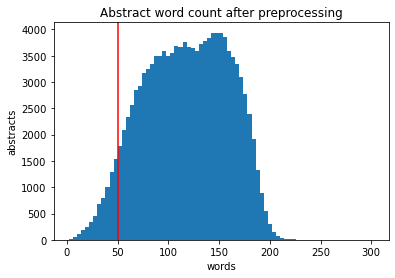

In [104]:
ax = corpus['preprocessed'].dropna().apply(lambda x: len(x.split(' '))).plot(kind='hist', bins=75)
ax.axvline(50, color='r')
ax.set_xlabel('words')
ax.set_ylabel('abstracts')
plt.title('Abstract word count after preprocessing')
plt.show()

Mark abstracts with at least 50 words.

In [132]:
corpus['is_preprocessed_ok'] = corpus['preprocessed'].apply(lambda x: len(x.split(' ')) >= 50 if x is not None else False)

,identifier,filename,spec,title,datestamp,created,updated,authors,categories,journal,doi,abstract,comments,filename_parsed,in_range,subcategories,is_single_domain,domain,preprocessed,is_preprocessed_ok
0,oai:arXiv.org:1710.06620,1710.06620,physics:astro-ph,Charged Anti-de Sitter BTZ black holes in Maxw...,2018-05-23,2017-10-18,2018-04-14,"G. G. L. Nashed, S. Capozziello",gr-qc astro-ph.HE hep-th,NaN,10.1142/S0217751X18500768,"Inspired by the BTZ formalism, we discuss th...",NaN,1710.06620,True,[astro-ph.HE],True,astro-ph.HE,inspired btz formalism discus maxwell f gravit...,True
1,oai:arXiv.org:1710.06624,1710.06624,physics:astro-ph,Non-Gaussian Error Distributions of Galactic R...,2018-08-14,2017-10-18,2018-02-20,"Ashwani Rajan, Shantanu Desai",astro-ph.IM astro-ph.GA astro-ph.HE physics.da...,"EPJP 133, 107 (2018)",10.1140/epjp/i2018-11946-7,We construct the error distributions for the...,NaN,1710.06624,True,"[astro-ph.IM, astro-ph.GA, astro-ph.HE]",False,None,None,False
2,oai:arXiv.org:1710.06628,1710.06628,physics:astro-ph,GAMA/G10-COSMOS/3D-HST: The 0<z<5 cosmic star-...,2018-02-21,2017-10-18,2017-10-19,"Simon P. Driver, Stephen K. Andrews, Elisabete...",astro-ph.GA astro-ph.CO,NaN,10.1093/mnras/stx2728,We use the energy-balance code MAGPHYS to de...,NaN,1710.06628,True,"[astro-ph.GA, astro-ph.CO]",False,None,None,False
3,oai:arXiv.org:1710.06630,1710.06630,physics:astro-ph,A detailed study of Lithium in 107 CHEPS dwarf...,2018-03-21,2017-10-18,NaN,"Ya. V. Pavlenko, J. S. Jenkins, O. M. Ivanyuk,...",astro-ph.SR,"A&A 611, A27 (2018)",10.1051/0004-6361/201731547,We report results from lithium abundance det...,NaN,1710.06630,True,[astro-ph.SR],True,astro-ph.SR,report result lithium abundance determination ...,True
4,oai:arXiv.org:1710.06659,1710.06659,physics:astro-ph,About the consistency of the energy scales of ...,2017-10-19,2017-10-18,NaN,Antonio Codino,astro-ph.HE,NaN,NaN,The energy spectrum of the cosmic radiation ...,NaN,1710.06659,True,[astro-ph.HE],True,astro-ph.HE,energy spectrum cosmic radiation range time ev...,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157983,oai:arXiv.org:1710.06557,1710.06557,physics:astro-ph,Atomic Gas in Blue Ultra Diffuse Galaxies arou...,2018-03-14,2017-10-17,2018-01-09,"Kristine Spekkens, Ananthan Karunakaran",astro-ph.GA,NaN,10.3847/1538-4357/aa94be,We have found the atomic gas (HI) reservoirs...,NaN,1710.06557,True,[astro-ph.GA],True,astro-ph.GA,found atomic gas hi reservoir blue ultra diffu...,True
157984,oai:arXiv.org:1710.06586,1710.06586,physics:astro-ph,$F_\gamma$: a new observable for photon-hadron...,2017-11-22,2017-10-18,2017-11-21,"M. Niechciol, M. Risse, P. Ruehl, M. Settimo, ...",astro-ph.HE astro-ph.IM,"Astropart. Phys. 97 (2018), 88-95",10.1016/j.astropartphys.2017.10.004,To search for ultra-high-energy photons in p...,NaN,1710.06586,True,"[astro-ph.HE, astro-ph.IM]",False,None,None,False
157985,oai:arXiv.org:1710.06599,1710.06599,physics:astro-ph,A history of violence: insights into post-accr...,2017-10-19,2017-10-18,NaN,"Brandon Mahan, Frederic Moynier, Pierre Beck, ...",astro-ph.EP,"Geochimica et Cosmochimica Acta 22, 19-35 (2018)",10.1016/j.gca.2017.09.027,Carbonaceous chondrites (CCs) may have been ...,NaN,1710.06599,True,[astro-ph.EP],True,astro-ph.EP,carbonaceous chondrite cc may carrier water vo...,True
157986,oai:arXiv.org:1710.06600,1710.06600,physics:astro-ph,Quantifying the AGN-driven outflows in ULIRGs ...,2017-12-20,2017-10-18,NaN,"Marvin Rose, Clive Tadhunter, Cristina Ramos A...",astro-ph.GA,NaN,10.1093/mnras/stx2590,Although now routinely incorporated into hyd...,NaN,1710.06600,True,[astro-ph.GA],True,astro-ph.GA,although routinely incorporated hydrodynamic s...,True


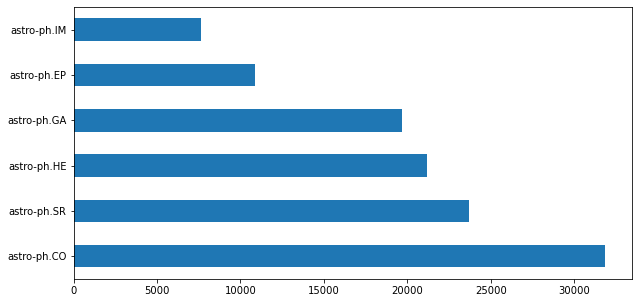

In [142]:
corpus[corpus['is_preprocessed_ok']]['domain'].value_counts().plot(kind='barh', figsize=(10,5))

## Train the model

Since we will be training a model with hyperparameters that need to be tuned, we need a validation set along with a test set. 


```
example: k-fold cross validation for hyperparameter optimization (k=3)

original data split into training and test set:

|---------------- train ---------------------|         |--- test ---|

cross-validation: test set is not used, error is calculated from
validation set (k-times) and averaged:

|---- train ------------------|- validation -|         |--- test ---|
|---- train ---|- validation -|---- train ---|         |--- test ---|
|- validation -|----------- train -----------|         |--- test ---|

final measure of model performance: model is trained on all training data
and the error is calculated from test set:

|---------------- train ---------------------|--- test ---|
```

To create these three sets:

1. we first randomly split our dataset into Train and Test using the common 80:20 ratio. 
2. We set aside the Test set. 
3. We pass the Train set to GridSearchCV, along with a set of parameters. GridSearchCV splits the train set into k folds, trains on k-1 folds and tests on the kth fold, and returns the best-performing model, based on its parameters.
4. We then evaluate the best model on the Test set.  

*Note: There is a [discussion](https://towardsdatascience.com/finally-why-we-use-an-80-20-split-for-training-and-test-data-plus-an-alternative-method-oh-yes-edc77e96295d) on how to choose best ratio. Here we just go with the conventional split, which is 80:20. In other situations, it may be worth looking into alternative ratios such as the scaling law, although oftentimes the increase in performance is small.*

We create the TF-IDF vectors for only the training set? https://stackoverflow.com/questions/46010617/do-i-use-the-same-tfidf-vocabulary-in-k-fold-cross-validation

In [166]:
subset = corpus[corpus['is_preprocessed_ok']]
domains = subset['domain'].value_counts().keys()
x_train, x_test, y_train, y_test = train_test_split(subset['preprocessed'], 
                                                    subset['domain'], 
                                                    test_size=0.2, 
                                                    random_state=42)
print('Training dataset:', len(x_train))
print('Test dataset:', len(x_test))

Training dataset: 91916
Test dataset: 22980


In [157]:
# Set up pipeline
pipeline = Pipeline([('tfidf', TfidfVectorizer()), # first step (feature transformer)
                    ('svm', SVC())]) # second step (classification model)

# Set parameters for TF-IDF
params = {'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
          'tfidf__max_df': [1.],
          'tfidf__min_df': [10],
          'tfidf__max_features': [10, 50, 100, 1000],
          'tfidf__norm': ['l2'],
          'tfidf__sublinear_tf': [True],
          'svc__kernel': ['rbf', 'linear']}

# Set up GridSearch
gs = GridSearchCV(pipeline, 
                  param_grid=params, 
                  scoring='accuracy', 
                  cv=5,
                  verbose=10, # the higher, the more verbose
                  n_jobs=3,
                  return_train_score=True)

# Fit the model
gs.fit(x_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed: 14.2min
[Parallel(n_jobs=3)]: Done   7 out of  10 | elapsed: 43.3min remaining: 18.6min
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed: 53.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svm', SVC())]),
             n_jobs=3,
             param_grid={'tfidf__max_df': [1.0], 'tfidf__max_features': [10],
                         'tfidf__min_df': [10],
                         'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__norm': ['l2'], 'tfidf__sublinear_tf': [True]},
             scoring='accuracy', verbose=10)

In [217]:
print("Best Estimator: \n{}\n".format(gs.best_estimator_))
print("Best Parameters: \n{}\n".format(gs.best_params_))
print("Best Test Score: \n{}\n".format(gs.best_score_))
print("Best Training Score: \n{}\n".format(gs.cv_results_['mean_train_score'][gs.best_index_]))
print("All Training Scores: \n{}\n".format(gs.cv_results_['mean_train_score']))
print("All Test Scores: \n{}\n".format(gs.cv_results_['mean_test_score']))
print("All Meta Results During CV Search: ")
pd.DataFrame(gs.cv_results_)

Best Estimator: 
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10, min_df=10,
                                 sublinear_tf=True)),
                ('svm', SVC())])

Best Parameters: 
{'tfidf__max_df': 1.0, 'tfidf__max_features': 10, 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 1), 'tfidf__norm': 'l2', 'tfidf__sublinear_tf': True}

Best Test Score: 
0.5011206005548605

All Test Scores: 
[0.5011206 0.5011206]

All Meta Results During CV Search: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfidf__max_df,param_tfidf__max_features,param_tfidf__min_df,param_tfidf__ngram_range,param_tfidf__norm,param_tfidf__sublinear_tf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,780.928867,33.693259,90.199651,7.831217,1,10,10,"(1, 1)",l2,True,"{'tfidf__max_df': 1.0, 'tfidf__max_features': ...",0.5,0.496763,0.499157,0.505141,0.504542,0.501121,0.003224,1
1,743.001389,103.278466,78.925501,9.249586,1,10,10,"(1, 2)",l2,True,"{'tfidf__max_df': 1.0, 'tfidf__max_features': ...",0.5,0.496763,0.499157,0.505141,0.504542,0.501121,0.003224,1


We want the train and test scores to be as close to one another as possible. If the train score is higher than the test score, the model might be overfitted on the train data. 

Score on the train set:

In [169]:
y_pred = gs.best_estimator_.predict(x_train)
print(classification_report(y_train, y_pred, target_names=domains))

              precision    recall  f1-score   support

 astro-ph.CO       0.46      0.72      0.56     25459
 astro-ph.SR       0.32      0.06      0.09      8689
 astro-ph.HE       0.58      0.37      0.45     15684
 astro-ph.GA       0.67      0.59      0.63     16952
 astro-ph.EP       0.34      0.12      0.18      6112
 astro-ph.IM       0.46      0.57      0.51     19020

    accuracy                           0.50     91916
   macro avg       0.47      0.41      0.40     91916
weighted avg       0.50      0.50      0.48     91916



Score on the test set:

In [180]:
y_pred_test = gs.best_estimator_.predict(x_test)
classification_report(y_test, y_pred_test, target_names=subdomains)
print(classification_report(y_test, y_pred_test, target_names=domains))

              precision    recall  f1-score   support

 astro-ph.CO       0.46      0.72      0.56      6389
 astro-ph.SR       0.30      0.05      0.09      2161
 astro-ph.HE       0.56      0.36      0.44      3987
 astro-ph.GA       0.66      0.59      0.62      4237
 astro-ph.EP       0.30      0.11      0.16      1504
 astro-ph.IM       0.45      0.57      0.50      4702

    accuracy                           0.50     22980
   macro avg       0.46      0.40      0.40     22980
weighted avg       0.49      0.50      0.47     22980



One reason why this may be so low is due to the imbalanced classes. We should perform again, undersampling to reach balanced classes.

Get the top correlated words with each category.

In [247]:
def get_correlated_ngrams(tfidf, features, y_train):
    all_bigrams = []
    all_unigrams = []
    for category in domains:
        features_chi2 = chi2(features, y_train == category)
        indices = np.argsort(features_chi2[0])
        feature_names = np.array(tfidf.get_feature_names())[indices]
        unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
        bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
        print("# '{}' category:".format(category))
        print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
        print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-5:])))
        print("")
        all_bigrams += bigrams
        all_unigrams += unigrams
    return all_unigrams, all_bigrams

unigrams, bigrams = get_correlated_ngrams(gs.best_estimator_['tfidf'], gs.best_estimator_['tfidf'].transform(pd.concat([x_train, x_test])).toarray(), pd.concat([y_train, y_test]))

# 'astro-ph.CO' category:
  . Most correlated unigrams:
. observation
. model
. ray
. galaxy
. star
  . Most correlated bigrams:
. 

# 'astro-ph.SR' category:
  . Most correlated unigrams:
. energy
. field
. ray
. star
. galaxy
  . Most correlated bigrams:
. 

# 'astro-ph.HE' category:
  . Most correlated unigrams:
. mass
. star
. galaxy
. energy
. ray
  . Most correlated bigrams:
. 

# 'astro-ph.GA' category:
  . Most correlated unigrams:
. model
. ray
. energy
. star
. galaxy
  . Most correlated bigrams:
. 

# 'astro-ph.EP' category:
  . Most correlated unigrams:
. observation
. energy
. field
. ray
. galaxy
  . Most correlated bigrams:
. 

# 'astro-ph.IM' category:
  . Most correlated unigrams:
. model
. star
. data
. galaxy
. mass
  . Most correlated bigrams:
. 



Difference between fit and transform: https://datascience.stackexchange.com/questions/12321/whats-the-difference-between-fit-and-fit-transform-in-scikit-learn-models

Fit the final model on all of the data. https://machinelearningmastery.com/train-final-machine-learning-model/

In [215]:
matrix = gs.best_estimator_['tfidf'].fit_transform(pd.concat([x_train, x_test])).toarray()

In [226]:
gs.best_estimator_['tfidf'].get_feature_names()

['data',
 'energy',
 'field',
 'galaxy',
 'mass',
 'model',
 'observation',
 'ray',
 'star',
 'time']

In [ ]:
tfidf = TfidfVectorizer(max_df=gs.best_params_['tfidf__max_df'],
                        min_df=gs.best_params_['tfidf__min_df'],
                        ngram_range=gs.best_params_['tfidf__ngram_range'],
                        max_features=gs.best_params_['tfidf__max_features'],
                        norm=gs.best_params_['tfidf__norm'],
                        sublinear_tf=gs.best_params_['tfidf__sublinear_tf'])
features = tfidf.fit_transform(pd.concat([x_train, x_test])).toarray()

To fix k-fold cv for imbalanced classification:
- https://stackoverflow.com/questions/61675761/gridsearchcv-stratifiedkfold-in-case-of-tfidf
- https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/

To combine multiple classifiers into one pipeline:
- https://stackoverflow.com/questions/50285973/pipeline-multiple-classifiers
- https://stackoverflow.com/questions/50265993/alternate-different-models-in-pipeline-for-gridsearchcv

## Visualize the best model

For convenience, we will prepare the data for the Embedding Projector (projector.tensorflow.org).

In [249]:
with open(GLOBALS['absolute_filepaths']['root'] + 'results/dec2020/1217_d2v.tsv', 'w') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t')
    for vector in features:
        writer.writerow(vector)
pd.concat([y_train, y_test]).to_frame().reset_index(drop=True).to_csv(GLOBALS['absolute_filepaths']['root'] + 'results/dec2020/1217_d2v_metadata.tsv', index=False, header=None)

Once we've found the best model using that tool, we can recreate the visualization here.